In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

# Convert heic files to jpg files

In [2]:
# import glob
# # Register the HEIF plugin
# import pillow_heif
# pillow_heif.register_heif_opener()

# # Convert files with baby
# file_names=glob.glob(r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Pictures\Train\Baby\*.heic')
# for name in file_names:
#     # Import image 
#     image=Image.open(name)
#     # All heifs aren't always in RGB. Convert to RGB.
#     image = image.convert("RGB")
#     image.save(f"{name[:-5]}.jpg", "JPEG")

# # Convert files wihtout baby
# file_names=glob.glob(r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Pictures\Train\NoBaby\*.heic')
# for name in file_names:
#     # Import image 
#     image=Image.open(name)
#     # All heifs aren't always in RGB. Convert to RGB.
#     image = image.convert("RGB")
#     image.save(f"{name[:-5]}.jpg", "JPEG")

# PreProcessing

In [9]:
# Directory to folders of images
# This directory contrains two folders, one called "Baby" and one called "NoBaby"
# We aren't doing seperate folders for train, test, and validation. We will split later.
directory=r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Pictures\CNN_Dataset'

# Create generator
data=tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=['NoBaby','Baby'], # First folder is class 0, second folder is class 1
    color_mode='rgb',
    batch_size=64, # default 32, 64 for faster performance
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 618 files belonging to 2 classes.


In [10]:
# Scale data to between 0 and 1
# map applies lambda function "in pipeline"
# x is the first element of our batch, or the images. y is the labels
data_scaled=data.map(lambda x,y: (x/255,y))

In [11]:
# Check the scaled data
print(data_scaled.as_numpy_iterator().next()[0].max())
print(data_scaled.as_numpy_iterator().next()[0].min())

1.0
0.0


# Split

In [12]:
# Manual "guess and check" process to divide batches into train, val, and test set
# This code is just selecting how many batches in each set
# Actual splitting happens in next cell

print(len(data_scaled)) # number of batches of data we have

train_size=int(len(data_scaled)*0.7) # 70% for train
val_size=int(len(data_scaled)*0.2) # 20% for validation
test_size=int(len(data_scaled)*0.1)+1 # 10% for test

print(train_size)
print(val_size)
print(test_size)
print(train_size+test_size+val_size)

10
7
2
2
11


In [13]:
# Set aside batches for train, validation, and test
# Data must be shuffled prior to doing this

train=data_scaled.take(train_size)
val=data_scaled.skip(train_size).take(val_size)
test=data_scaled.skip(train_size+val_size).take(test_size)

# Augment Training Set data

In [16]:
# This will help prevent overfitting

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change the brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly change contrast
    return image, label

# Apply the augmentation in-pipeline
train_augmented = train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

### Model Architecture

In [18]:
# This is a farily simple model. We will build sequentially.
model = Sequential()

In [19]:
# 32 filters in convulution, more than before for more predictive power
# each filter is of size 3x3 pixels
# stride of 1
model.add(Conv2D(32,(3,3),1,activation='relu',input_shape=(256,256,3)))
# Condenses information
# Default is 2x2 region. So takes max value out of 2x2 region
# Halves the data
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [21]:
# Set the learning rate
# Experimented with lower learning rates, ended up back at the default
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer,loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Model Training

In [24]:
hist = model.fit(train,epochs=30,validation_data=val)

Epoch 1/30
7/7 [==============================] - 89s 10s/step - loss: 1.9236 - accuracy: 0.5379 - val_loss: 0.6827 - val_accuracy: 0.5469
Epoch 2/30
7/7 [==============================] - 77s 9s/step - loss: 0.6698 - accuracy: 0.5759 - val_loss: 0.6925 - val_accuracy: 0.4766
Epoch 3/30
7/7 [==============================] - 74s 9s/step - loss: 0.6939 - accuracy: 0.6094 - val_loss: 0.5942 - val_accuracy: 0.7188
Epoch 4/30
7/7 [==============================] - 73s 9s/step - loss: 0.6094 - accuracy: 0.6808 - val_loss: 0.6009 - val_accuracy: 0.7266
Epoch 5/30
7/7 [==============================] - 77s 9s/step - loss: 0.5866 - accuracy: 0.7188 - val_loss: 0.5322 - val_accuracy: 0.7422
Epoch 6/30
7/7 [==============================] - 77s 10s/step - loss: 0.5544 - accuracy: 0.7143 - val_loss: 0.4681 - val_accuracy: 0.7891
Epoch 7/30
7/7 [==============================] - 75s 9s/step - loss: 0.5166 - accuracy: 0.7321 - val_loss: 0.4389 - val_accuracy: 0.8125
Epoch 8/30
7/7 [================

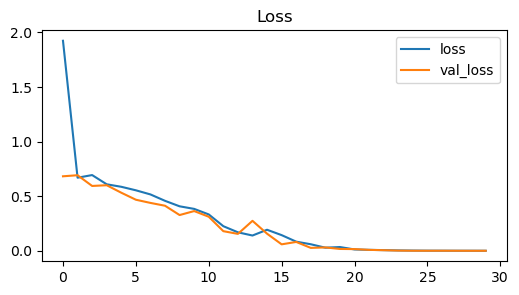

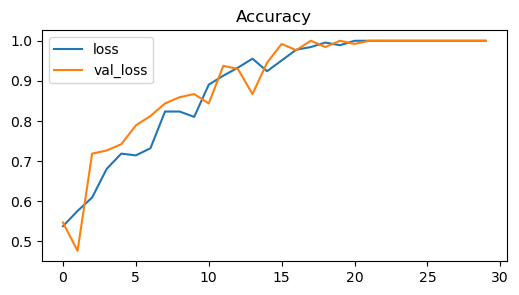

In [26]:
# Plot loss function for train and validation set

plt.figure(figsize=(6,3))
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

# Plot accuracy of train and validation set

plt.figure(figsize=(6,3))
plt.plot(hist.history['accuracy'],label='loss')
plt.plot(hist.history['val_accuracy'],label='val_loss')
plt.title('Accuracy')
plt.legend()
plt.show()

### Model Evaluation

##### Threshold optimization on validation set

2/2 [==============================] - 2s 827ms/step


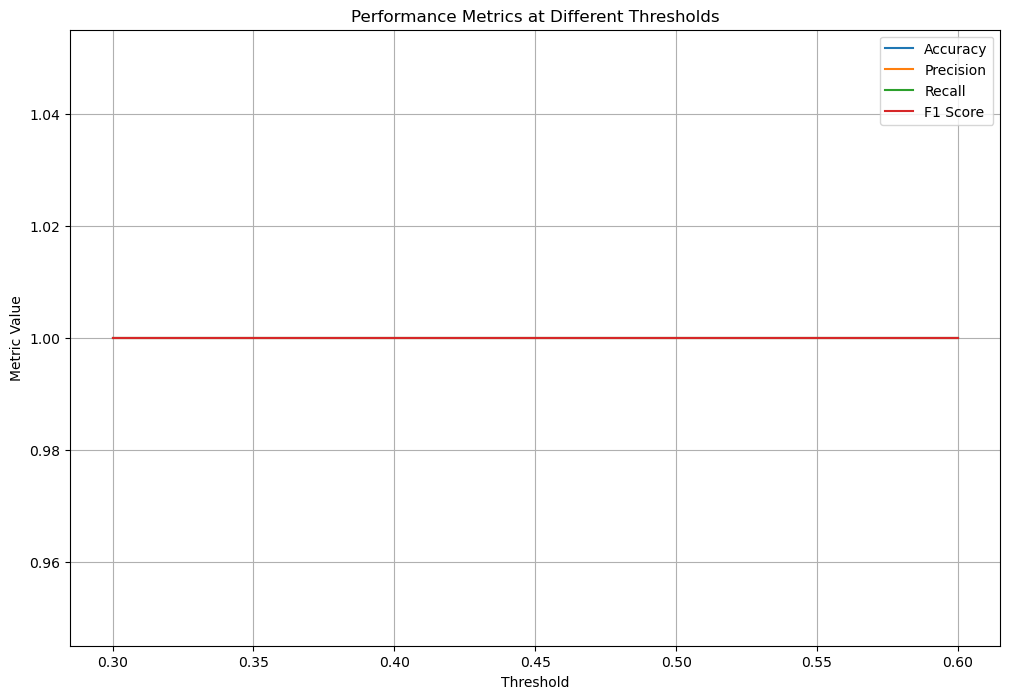

Optimal Threshold: 0.30
Optimal F1 Score: 1.0000


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store true labels and predicted probabilities
y_true = []
y_prob = []

# Iterate over the validation dataset batches
for batch in val.as_numpy_iterator():
    X, y = batch
    
    # Make predictions (probabilities for binary classification)
    predictions = model.predict(X)
    
    # Append true labels and predicted probabilities to the lists
    y_true.extend(y)
    y_prob.extend(predictions.flatten())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Define a range of thresholds to evaluate
thresholds = np.arange(0.3, 0.65, 0.05)

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Evaluate each threshold
for threshold in thresholds:
    # Convert probabilities to binary class labels based on the current threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Plot the metrics against the thresholds
plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Identify the optimal threshold (example: max F1 score)
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Optimal F1 Score: {f1_scores[optimal_threshold_index]:.4f}")


In [29]:
# All the thresholds were the same, so setting to 0.5
optimal_threshold=0.5

##### Test set evaluation with optimized threshold

2/2 [==============================] - 1s 250ms/step
Calculated Accuracy: 1.0000


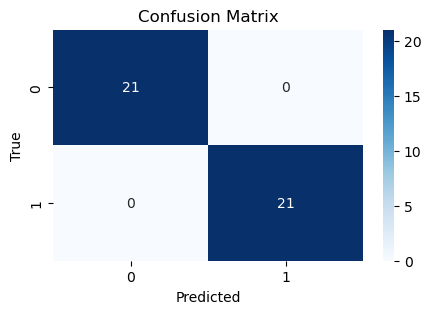

In [31]:
import seaborn as sns

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test dataset batches
for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Make predictions (probabilities for binary classification)
    predictions = model.predict(X)
    
    # Convert probabilities to class labels (0 or 1) based on a threshold
    predicted_labels = (predictions > optimal_threshold).astype(int)
    
    # Append true and predicted labels to the lists
    y_true.extend(y)
    y_pred.extend(predicted_labels.flatten())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy using sklearn's accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Calculated Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn's heatmap
plt.figure(figsize=(5,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Save Model

In [33]:
os.chdir(r'C:\Users\gregoryd\Documents\Ben\OpenCV\LuciaIdentifier\Models')
model.save('20240817_BabyIdentifier.keras')